# Random Operators: random quantum states and channels

In the context of `forest-benchmarking` the primary use of random operators is to test the estimation routines.

For example you might modify a existing state or process tomography routine (or develop a new method) and want to test that your modification works. One way to do that would be to test it on a bunch of random quantum states or channels. 

In [1]:
import numpy as np
import forest.benchmarking.operator_tools.random_operators as rand_ops

## Random Operators

### Complex Ginibre ensemble

This is a subroutine for other methods in the module. The complex Ginibre ensemble is a random matrix where the real and imaginary parts of each entry, $G(n,m)$, are drawn in and IID fashion from $\mathcal N(0,1)$ e.g.

$$G(n,m) = X(n,m) + i Y(n,m)$$

where $X(n,m), Y(n,m)\sim \mathcal N(0,1)$. For our purpose we allow for non square matricies.

In [2]:
gini_2by2 = rand_ops.ginibre_matrix_complex(2,2)
print(gini_2by2)

print('Notice that the above matrix is not Hermitian.')
print('We can explicitly test if it is Hermitian = ', np.all(gini_2by2.T.conj()==gini_2by2))

[[ 0.51783784+1.59579831j  0.22219084-0.08506946j]
 [ 0.44832176+0.77277708j -0.68330944+0.43481616j]]
Notice that the above matrix is not Hermitian.
We can explicitly test if it is Hermitian =  False


### Haar random unitary

Here you simply specify the dimesion of the Hilbert space. 

In [3]:
U = rand_ops.haar_rand_unitary(2)
print(U)

[[ 0.31784186+0.74235425j  0.04899764+0.58778052j]
 [ 0.12099686-0.57727504j -0.40682771+0.69757043j]]


We can test to see how unitary it is:

In [4]:
print(np.around(U.dot(np.transpose(np.conj(U))),decimals=15))
print(np.around(U.dot(np.transpose(np.conj(U))),decimals=16))

[[1.+0.j 0.-0.j]
 [0.+0.j 1.-0.j]]
[[1.+0.e+00j 0.-1.e-16j]
 [0.+1.e-16j 1.-0.e+00j]]


Apparently it is only good to 16 decimal places.

## Random States

### Haar random pure state

The simpliest random state is a state drawn from the Haar measure. It is a pure state, i.e. the purity is $P(\rho)={\rm Tr}[\rho^2]=1$. These states are generated by applying a Haar random unitary to a fixed fuduial state, usually $|0\ldots0\rangle$.

In [5]:
psi2 = rand_ops.haar_rand_state(2)
print('The state vector is \n', psi2, )
print('It has shape', psi2.shape,'and purity P = ', np.round(np.trace(psi2@psi2.T.conj()@psi2@psi2.T.conj()),2))
print('\n')
print('Now lets look at a random pure state on two qubits')
psi4 = rand_ops.haar_rand_state(4)
print('The state vector is \n', psi4, )
print('It has shape', psi4.shape,'.')

The state vector is 
 [[0.30195045-0.7933957j]
 [0.20713655-0.4862547j]]
It has shape (2, 1) and purity P =  (1-0j)


Now lets look at a random pure state on two qubits
The state vector is 
 [[ 0.19914674+0.28997926j]
 [-0.68868807+0.37357005j]
 [ 0.48884613-0.10562828j]
 [ 0.06850955+0.08709377j]]
It has shape (4, 1) .


For fun lets plot the state in the Pauli representation.

In [6]:
from forest.benchmarking.plotting.state_process import plot_pauli_rep_of_state
from forest.benchmarking.operator_tools.superoperator_transformations import computational2pauli_basis_matrix, vec 
from forest.benchmarking.utils import n_qubit_pauli_basis
import matplotlib.pyplot as plt

# change of basis
n_qubits = 2
pl_basis_twoq = n_qubit_pauli_basis(n_qubits)
c2p_twoq = computational2pauli_basis_matrix(2*n_qubits)

# turn a state vector into a state matrix
rho = psi4@psi4.T.conj()
# convert the state to the Pauli representation which should be real
state = np.real(c2p_twoq@vec(rho))

fig, ax = plt.subplots()
plot_pauli_rep_of_state(state.transpose(), ax, pl_basis_twoq.labels, 'Random Two qubit state in Pauli representation')

### Ginibre State (mixed state with rank K)

This function lets us generate mixed states with a specific rank.

Specifically, given a Hilbert space dimension $D$ and a desired rank $K$, this function 
a D by D positive semidefinite matrix of rank $K$ drawn from the Ginibre ensemble. 
 
For $D = K$ these are states drawn from the **Hilbert-Schmidt measure**.

In [10]:
print('This is a mixed single qubit state drawn from Hilbert-Schmidt measure (as D=K)')
print(np.around(rand_ops.ginibre_state_matrix(2,2),4))
print("\n")
print('This is a mixed two qubit state with rank 2:')
print(np.around(rand_ops.ginibre_state_matrix(4,2),4))
evals, evec = np.linalg.eig(rand_ops.ginibre_state_matrix(4,2))
print('\n')
print('Here are the eigenvalues:', np.round(evals,3),'. You can see only two are non zero.')

This is a mixed single qubit state drawn from Hilbert-Schmidt measure (as D=K)
[[0.2243-0.j     0.1617+0.0408j]
 [0.1617-0.0408j 0.7757+0.j    ]]


This is a mixed two qubit state with rank 2:
[[ 0.3435+0.j      0.0503+0.1182j -0.007 -0.0502j -0.1974+0.0158j]
 [ 0.0503-0.1182j  0.3327-0.j      0.003 +0.1373j  0.14  -0.0304j]
 [-0.007 +0.0502j  0.003 -0.1373j  0.0802-0.j     -0.0364-0.1184j]
 [-0.1974-0.0158j  0.14  +0.0304j -0.0364+0.1184j  0.2436-0.j    ]]


Here are the eigenvalues: [0.   +0.j 0.337-0.j 0.663-0.j 0.   -0.j] . You can see only two are non zero.


### State from Bures measure

In [11]:
rand_ops.bures_measure_state_matrix(2)

array([[ 0.41135882+0.j        , -0.12971395+0.20328594j],
       [-0.12971395-0.20328594j,  0.58864118+0.j        ]])

## Random quantum Channels

### Uniform ensemble of CPTP maps (BCSZ distribution)

Given a Hilbert space dimension $D$ and a Kraus rank $K$, this function returns a $D^2 × D^2$ Choi matrix $J(Λ)$ of a channel drawn from the BCSZ distribution with Kraus rank $K$.

In [12]:
rand_choi = rand_ops.rand_map_with_BCSZ_dist(2,2)
print('Here is a random quantum channel on one qubit in Choi form:')
rand_choi

Here is a random quantum channel on one qubit in Choi form:


array([[ 0.46089813+3.46944695e-18j,  0.27874737-3.47538997e-01j,
         0.07274096-1.05089882e-01j, -0.03975122-5.30473244e-02j],
       [ 0.27874737+3.47538997e-01j,  0.53910187-2.60208521e-18j,
         0.23673647-2.42995364e-01j, -0.07274096+1.05089882e-01j],
       [ 0.07274096+1.05089882e-01j,  0.23673647+2.42995364e-01j,
         0.66032833+1.38777878e-17j, -0.44807263-3.41252393e-02j],
       [-0.03975122+5.30473244e-02j, -0.07274096-1.05089882e-01j,
        -0.44807263+3.41252393e-02j,  0.33967167-1.73472348e-18j]])

In [13]:
rand_choi.shape

(4, 4)

To convert to different superoperator representations we import the module `operator_tools.superoperator_transformations`

In [14]:
import forest.benchmarking.operator_tools.superoperator_transformations as sot
print('We can convert this channel to Kraus form and enumerate the Kraus operators.')

for idx, kraus_op in enumerate(sot.choi2kraus(rand_choi)):
    print('Kraus OP #'+str(1+idx)+' is: \n', kraus_op)

We can convert this channel to Kraus form and enumerate the Kraus operators.
Kraus OP #1 is: 
 [[0.53125657+0.j         0.03521529-0.36863168j]
 [0.12883999+0.32986757j 0.00258408+0.41559292j]]
Kraus OP #2 is: 
 [[-0.42268734-0.j         -0.12783115-0.71193967j]
 [-0.49753153-0.40761732j  0.09729184+0.39683978j]]


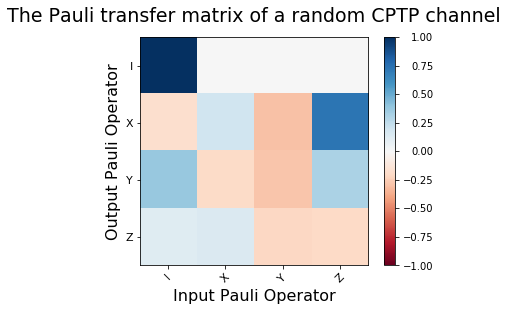

In [15]:
rand_pl = sot.choi2pauli_liouville(rand_choi)


from forest.benchmarking.plotting.state_process import plot_pauli_transfer_matrix
n_qubits = 1
pl_basis_oneq = n_qubit_pauli_basis(n_qubits)
c2p_oneq = computational2pauli_basis_matrix(2*n_qubits)

f, (ax1) = plt.subplots(1, 1, figsize=(5.5, 4.2))
plot_pauli_transfer_matrix(np.real(rand_pl), ax1, pl_basis_oneq.labels, 'The Pauli transfer matrix of a random CPTP channel')
plt.show()

## Permutations of operators on tensor product Hilbert spaces

In [16]:
# pick a hilbert space dimension
D = 2

Lets consider a tensor product of three Hilbert spaces: $$\mathcal H_a \otimes \mathcal H_b\otimes \mathcal H_c.$$ 

Next we need to pick a way you want to permute the operators; specified by a permutation in [cycle notation](https://en.wikipedia.org/wiki/Permutation#Cycle_notation). 

For example the Identity permutation is $P = [0,1,2]$ which maps $(a,b,c)$ to $(a,b,c)$.
The permutation $P = [1,2,0]$ maps $(a,b,c)$ to $(b,c,a)$, so lets try that.

In [17]:
perm =[1,2,0]
# Note: the number of elements in the permutation determines 
#       the number of Hilbert spaces you are considering.

Create the basis states in the Hilbert space

In [18]:
basis = list(range(0,D))
states = []
for jdx in basis:
    emptyvec = np.zeros((D,1))
    emptyvec[jdx] =1
    states.append(emptyvec)

Create inital state and answer after applying the permutation [1,2,0]

In [19]:
# before permuting anything
inital_vector = np.kron(np.kron(states[0],states[0]),states[1]) 

# apply the permutation by hand
perm_vector = np.kron(np.kron(states[0],states[1]),states[0]) 

**create permutation operator**

In [20]:
P_120 = rand_ops.permute_tensor_factors(D, perm)

**check the permutation operator applied to the intial vector gives the correct answer**

In [21]:
answer = np.matmul(P_120,inital_vector)

In [22]:
print('The inner product between the calculated and true answer is one', np.matmul(perm_vector.T,answer))

The inner product between the calculated and true answer is one [[1.]]
